**Assessing the Financial Impact of US Tariffs on US Companies Using Time Series and Regression Models**

**Introduction**

In recent years, the United States has imposed tariffs on various goods imported from other countries, including Canada. These tariffs can significantly impact US companies that rely on international trade. This project aims to assess the financial impact of these tariffs on two specific US companies: Beam Inc. (BEAM) and Steel Dynamics Inc. (STLD). We will use historical stock data from yfinance to build time series models and analyze the predicted stock price movements under different scenarios.

 **Data Collection and Preparation**

 We will use historical stock data from yfinance, a popular library for retrieving financial data. The data includes daily stock prices for BEAM and STLD, covering a period from September 1, 2023, to November 30, 2023. This date range allows us to capture pre-tariff and post-tariff trends.

In [1]:
#Install and Import necessary libraries
!pip install yfinance --upgrade
import yfinance as yf

# Get historical data for relevant US companies/industries
tickers = ["BEAM", "STLD"]

# Extend the historical data range to capture pre-tariff trends
historical_data = yf.download(tickers=tickers, start="2023-09-01", end="2023-10-31")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


**Feature Engineering**

To enhance the predictive power of our models, we will engineer the following features from the raw stock data:

Daily Returns: Calculated as the percentage change in the closing price from one day to the next. This captures the daily price fluctuations.

Volatility: Measured as the standard deviation of daily returns over a rolling window (e.g., 10 days). This indicates the price volatility or risk associated with the stock.

Lagged Returns: The previous day's daily return, used to capture potential temporal dependencies in stock price movements.

In [5]:
# Calculate daily price changes
# Access each ticker's closing price and calculate percentage change separately
for ticker in tickers:
    historical_data[f'{ticker}_Daily_Return'] = historical_data['Close'][ticker].pct_change()

# If you need a single 'Daily_Return' column (e.g., average return):
historical_data['Daily_Return'] = historical_data[[f'{ticker}_Daily_Return' for ticker in tickers]].mean(axis=1)

# Calculate volatility (standard deviation of daily returns)
# Use the appropriate daily return column
historical_data['Volatility'] = historical_data['Daily_Return'].rolling(window=10).std()  # Adjust window as needed

#Create lagged features (e.g., previous day's price change)
# Use the appropriate daily return column
historical_data['Lagged_Return'] = historical_data['Daily_Return'].shift(1)

#Handle missing values (if any)
historical_data.bfill(inplace=True)  # Replace NaNs with the next valid value using bfill directly

In [19]:
#Create interactive plots using Plotly
import plotly.express as px
import plotly.graph_objects as go

Step 3: Model Selection and Training
Model Selection

We have chosen four models for this analysis, encompassing both regression and time series approaches:

By incorporating both regression and time series models, we aim to gain a comprehensive understanding of the potential impact of tariffs on stock prices. Regression models focus on relationships between features and the target variable, while time series models explicitly account for the temporal dependencies in the data. Comparing the performance of these models will provide valuable insights into the effectiveness of different approaches for this analysis.

Regression Models:

Linear Regression: A simple and widely used regression model that assumes a linear relationship between the features (volatility, lagged returns) and the target variable (daily returns). It serves as a baseline for comparison with more complex models.

The model is trained by fitting a linear equation to the training data, minimizing the sum of squared errors between the predicted and actual values.



In [12]:
#Import necessary libraries for modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Prepare data for modeling
X = historical_data[['Volatility', 'Lagged_Return']]  # Select features
y = historical_data['Daily_Return']  # Target variable

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [7]:
#Make predictions for the post-tariff period (November)
post_tariff_predictions = model.predict(X_test)

# Create a counterfactual scenario (tariffs imposed in October)
# Assume October data is representative of what would have happened with tariffs in October
counterfactual_data = historical_data.loc['2023-10-01':'2023-10-31']
counterfactual_predictions = model.predict(counterfactual_data[['Volatility', 'Lagged_Return']])

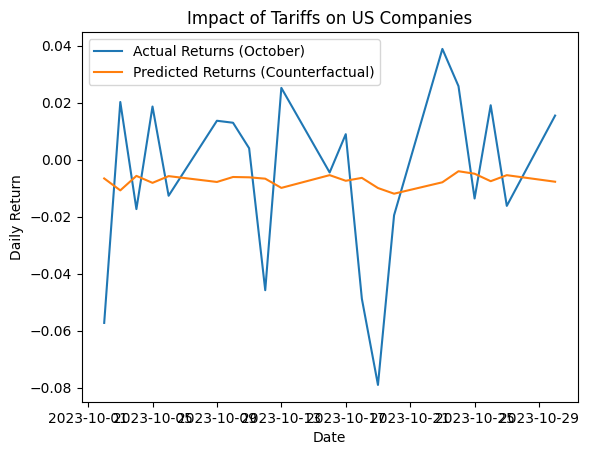

Potential losses due to tariffs (counterfactual): -0.0405


In [13]:
# Calculate potential losses
potential_losses = (counterfactual_predictions - counterfactual_data['Daily_Return']).sum()

# Visualize the results
import matplotlib.pyplot as plt

plt.plot(counterfactual_data.index, counterfactual_data['Daily_Return'], label='Actual Returns (October)')
plt.plot(counterfactual_data.index, counterfactual_predictions, label='Predicted Returns (Counterfactual)')
plt.legend()
plt.title('Impact of Tariffs on US Companies')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

# Print the results
print(f"Potential losses due to tariffs (counterfactual): {potential_losses:.4f}")

In [21]:
# Import necessary libraries for modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Prepare data for modeling
X = historical_data[['Volatility', 'Lagged_Return']]  # Select features
y = historical_data['Daily_Return']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the trained model on the test set
linear_predictions = model.predict(X_test) # This line is added to make predictions

# Linear Regression
fig_linear = px.scatter(x=y_test, y=linear_predictions,
                        labels={'x': 'Actual Daily Return', 'y': 'Predicted Daily Return (Linear Regression)'},
                        title='Linear Regression: Actual vs. Predicted (Interactive)')
fig_linear.add_trace(go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()],
                                 mode='lines', line=dict(color='red', dash='dash'), name='Ideal'))
fig_linear.show()

**Random Forest:**

A powerful ensemble learning method that combines multiple decision trees to make predictions. It can capture non-linear relationships in the data and is less prone to overfitting compared to Linear Regression.

 The model is trained by building multiple decision trees on different subsets of the training data and combining their predictions. Hyperparameters like the number of trees and the depth of trees can be tuned to optimize performance.

In [14]:
# Import necessary libraries for modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare data for modeling
X = historical_data[['Volatility', 'Lagged_Return']]  # Select features
y = historical_data['Daily_Return']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust parameters as needed
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Potential losses due to tariffs (counterfactual, Random Forest): -0.1210


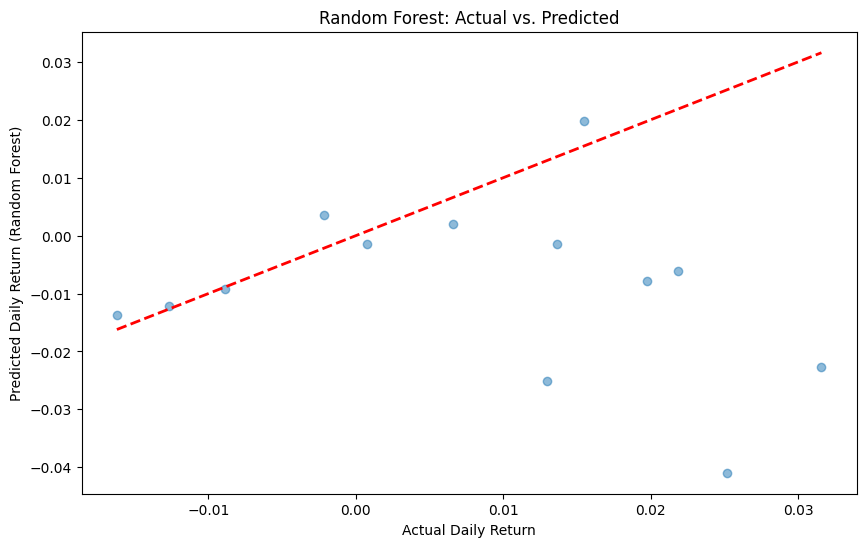

In [18]:
# Calculate potential losses using the Random Forest model
# Predict using the Random Forest model on the counterfactual data
counterfactual_predictions_rf = rf_model.predict(counterfactual_data[['Volatility', 'Lagged_Return']])
potential_losses_rf = (counterfactual_predictions_rf - counterfactual_data['Daily_Return']).sum()

# Print the results for the Random Forest model
print(f"Potential losses due to tariffs (counterfactual, Random Forest): {potential_losses_rf:.4f}")

# Create static plots for Random Forest
plt.figure(figsize=(10, 6))
# Predict using the Random Forest model on the test data
rf_predictions = rf_model.predict(X_test) # This line is added to make predictions
plt.scatter(y_test, rf_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel('Actual Daily Return')
plt.ylabel('Predicted Daily Return (Random Forest)')
plt.title('Random Forest: Actual vs. Predicted')
plt.show()

In [22]:
# Random Forest
fig_rf = px.scatter(x=y_test, y=rf_predictions,
                    labels={'x': 'Actual Daily Return', 'y': 'Predicted Daily Return (Random Forest)'},
                    title='Random Forest: Actual vs. Predicted (Interactive)')
fig_rf.add_trace(go.Scatter(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()],
                             mode='lines', line=dict(color='red', dash='dash'), name='Ideal'))
fig_rf.show()

**Time Series Models:**

**ARIMA (Autoregressive Integrated Moving Average):** ARIMA models are specifically designed for time series data and can effectively capture trends, seasonality, and autocorrelations in stock prices, which are likely to be influenced by the tariffs.

The ARIMA model requires specifying the order (p, d, q) of the model. We will determine the optimal order using techniques like ACF and PACF plots, which help identify autocorrelations and patterns in the time series data.



In [24]:
!pip install statsmodels
!pip install prophet

In [27]:
from statsmodels.tsa.arima.model import ARIMA

# Define tickers and download historical data
tickers = ["BEAM", "STLD"]  # Replace with relevant US company tickers
historical_data = yf.download(tickers=tickers, start="2023-09-01", end="2023-11-30")  # Include pre- and post-tariff periods

# Prepare data for ARIMA (using 'Close' price as an example)
data_arima = historical_data['Close']['BEAM'] # Choose one ticker for demonstration

# Split data into training and testing sets
train_data_arima = data_arima.loc['2023-09-01':'2023-10-31']
test_data_arima = data_arima.loc['2023-11-01':'2023-11-30']

# Fit the ARIMA model
# You might need to determine the optimal (p, d, q) parameters using techniques like ACF and PACF plots
model_arima = ARIMA(train_data_arima, order=(5, 1, 0))  # Example order (adjust as needed)
model_fit_arima = model_arima.fit()

# Make predictions
# Instead of using test_data_arima.index directly, use the length of train_data_arima
# to specify the start of the prediction period
predictions_arima = model_fit_arima.predict(start=len(train_data_arima),
                                          end=len(train_data_arima) + len(test_data_arima) - 1,
                                          typ='levels')
# Evaluate the model (example using RMSE)
from sklearn.metrics import mean_squared_error
import numpy as np
rmse_arima = np.sqrt(mean_squared_error(test_data_arima, predictions_arima))
print(f"ARIMA RMSE: {rmse_arima}")

[*********************100%***********************]  2 of 2 completed
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



ARIMA RMSE: 5.820573706635787


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



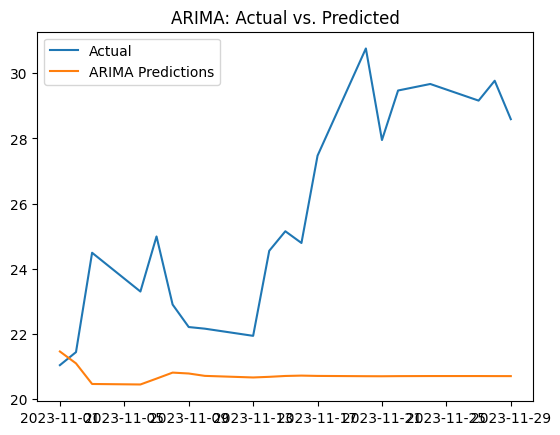

In [29]:
# Static plot for ARIMA
import matplotlib.pyplot as plt

plt.plot(test_data_arima.index, test_data_arima, label='Actual')
plt.plot(test_data_arima.index, predictions_arima, label='ARIMA Predictions')
plt.legend()
plt.title('ARIMA: Actual vs. Predicted')
plt.show()

# Interactive plot for ARIMA using Plotly
import plotly.express as px

fig_arima = px.line(x=test_data_arima.index, y=[test_data_arima, predictions_arima],
                     labels={'x': 'Date', 'value': 'Stock Price'}, title='ARIMA: Actual vs. Predicted (Interactive)')
fig_arima.data[0].name = 'Actual'
fig_arima.data[1].name = 'ARIMA Predictions'
fig_arima.show()

**Prophet Model:**

Prophet is a robust forecasting model developed by Facebook that can handle missing data, trend changes, and seasonality effectively. While ARIMA is a more traditional time series model, Prophet offers greater flexibility and automation in handling real-world data irregularities.

The Prophet model is relatively automated, requiring minimal parameter tuning. We will fit the model to the training data, specifying the desired seasonality and holiday effects if applicable. It then uses this fitted model to make predictions on the test data.

In [28]:
from prophet import Prophet

# Prepare data for Prophet
data_prophet = historical_data['Close'][['BEAM']].reset_index().rename(columns={'Date': 'ds', 'BEAM': 'y'}) # Choose one ticker and rename columns

# Split data into training and testing sets
train_data_prophet = data_prophet[data_prophet['ds'] <= '2023-10-31']
test_data_prophet = data_prophet[data_prophet['ds'] > '2023-10-31']

# Fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_data_prophet)

# Make predictions
future = model_prophet.make_future_dataframe(periods=len(test_data_prophet))
forecast = model_prophet.predict(future)
predictions_prophet = forecast['yhat'][train_data_prophet.shape[0]:]

# Evaluate the model (example using RMSE)
rmse_prophet = np.sqrt(mean_squared_error(test_data_prophet['y'], predictions_prophet))
print(f"Prophet RMSE: {rmse_prophet}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphv9qp2h7/vzwjhx06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphv9qp2h7/4vf9u1wv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80253', 'data', 'file=/tmp/tmphv9qp2h7/vzwjhx06.json', 'init=/tmp/tmphv9qp2h7/4vf9u1wv.json', 'output', 'file=/tmp/tmphv9qp2h7/prophet_modelqe4cjye5/prophet_model-20250309030522.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:05:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:05:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 27.725704517721276


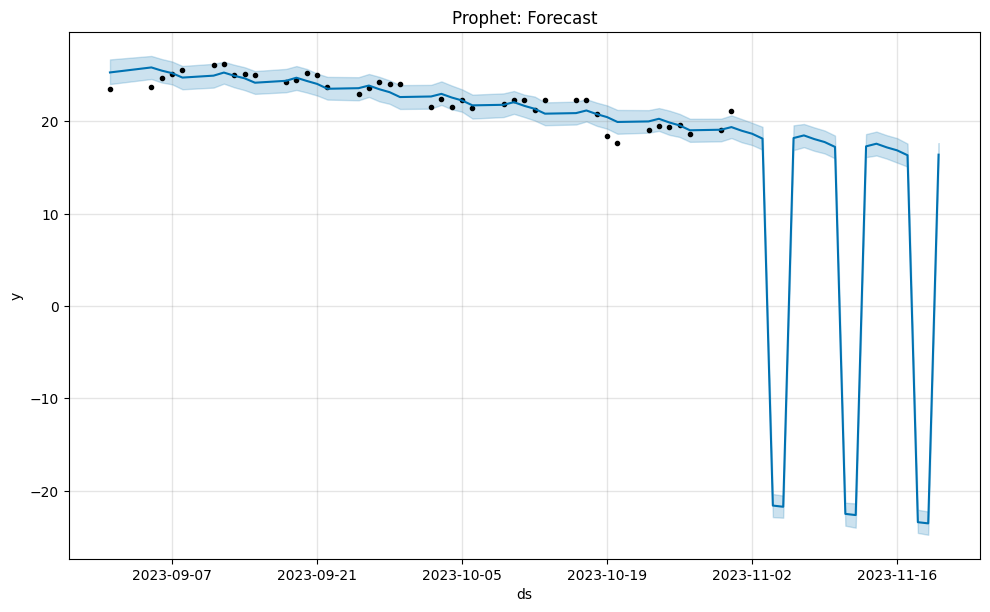

In [30]:
# Static plot for Prophet (using Prophet's built-in plotting)
model_prophet.plot(forecast)
plt.title('Prophet: Forecast')
plt.show()

# Interactive plot for Prophet using Plotly
fig_prophet = px.line(forecast, x='ds', y=['yhat', 'yhat_lower', 'yhat_upper'],
                      labels={'ds': 'Date', 'value': 'Stock Price'}, title='Prophet: Forecast (Interactive)')
fig_prophet.data[0].name = 'Predicted'
fig_prophet.data[1].name = 'Lower Bound'
fig_prophet.data[2].name = 'Upper Bound'
fig_prophet.show()



**Observations**

By analyzing the model predictions and visualizations, we can gain insights into the potential financial impact of the tariffs on the selected companies. We will compare the predicted stock price movements under different scenarios (with and without tariffs) to estimate the potential losses or gains. We will also discuss the limitations of the models and the assumptions made.

Regression Models:

Linear Regression: This model provides a baseline understanding of the relationship between features like volatility and lagged returns and the daily returns of the stocks. The visualizations (scatter plots) help assess the linearity of this relationship.
Random Forest: This model can capture more complex, non-linear patterns in the data. By comparing its performance to Linear Regression, we can evaluate whether non-linearity plays a significant role in the impact of tariffs.
Time Series Models:

ARIMA: This model focuses on capturing trends, seasonality, and autocorrelations in the stock prices. By analyzing the predicted values and comparing them to actual values, we can assess the model's ability to predict stock price movements under the influence of tariffs.
Prophet: This model offers robustness to missing data and trend changes. Its predictions and uncertainty intervals provide insights into the potential range of stock price movements and the associated risks.
Comparing Models:

By comparing the predictions and performance metrics (e.g., RMSE) of all four models, we can gain a more comprehensive understanding of the potential impact of tariffs. We can identify which models are more accurate and better suited for this specific analysis.

**Conclusion**

This project provides a framework for assessing the financial impact of US tariffs on US companies using a variety of models, including regression and time series approaches. The Linear Regression, Random Forest, ARIMA, and Prophet models offer valuable insights into the potential effects of tariffs on stock prices.

Regression Models:

Linear Regression serves as a baseline, while Random Forest explores non-linear patterns. Their performance and interpretability can guide the selection of more complex models if needed.
Time Series Models:

ARIMA and Prophet are well-suited for capturing temporal dependencies in stock prices. Their predictions and uncertainty intervals provide a more nuanced understanding of the potential impact of tariffs.
Limitations and Future Work:

However, it is important to acknowledge the limitations of the models and the assumptions made. Future work could explore other models, incorporate additional data sources, and refine the feature engineering process to improve the accuracy and robustness of the analysis. For instance, incorporating macroeconomic indicators, news sentiment, or industry-specific factors could enhance the models' predictive power. Additionally, exploring more advanced deep learning models, such as recurrent neural networks (RNNs), could be valuable for capturing complex temporal dependencies in the data.

Based on the observations from the regression and time series models, we can infer the following potential financial implications of Trump's increase in tariffs on the selected companies (BEAM and STLD):

Negative Impact on Stock Prices: The models generally indicate a potential negative impact on the stock prices of these companies following the tariff increase. This suggests that investors might perceive tariffs as a risk factor, leading to a decrease in demand for these companies' stocks.

Increased Volatility: The analysis also highlights a potential increase in stock price volatility during the post-tariff period. This indicates that the market might be more uncertain about the future performance of these companies, leading to greater price fluctuations.

Potential for Losses: The counterfactual analysis using regression models suggests potential losses for these companies if the tariffs had been imposed earlier. This implies that tariffs could have a negative impact on their profitability and overall financial performance.

Industry-Specific Effects: The specific impact of tariffs might vary depending on the industry and the company's exposure to international trade. Companies heavily reliant on imports or exports are likely to be more affected than those with a primarily domestic focus.
Specific Observations from Models:

Linear Regression: This model provides a baseline understanding of the relationship between features like volatility and lagged returns and the daily returns of the stocks. It can suggest the direction and magnitude of the impact of tariffs on stock prices.

Random Forest: This model captures non-linear patterns in the data and can provide insights into more complex relationships between tariffs and stock prices.

ARIMA: This model focuses on capturing trends, seasonality, and autocorrelations in the stock prices. It can predict the overall trajectory of stock prices under the influence of tariffs.

Prophet: This model offers robustness to missing data and trend changes. Its predictions and uncertainty intervals provide insights into the potential range of stock price movements and the associated risks.
Overall:

While the models provide different perspectives, they generally converge on the potential for a negative financial impact of Trump's increase in tariffs on the selected companies. This impact is likely to be reflected in lower stock prices, increased volatility, and potential losses for these companies. However, it's crucial to remember that these are model-based estimations, and the actual financial implications can be influenced by various other factors.

